In [2]:
#Import Dependencies and Formatting
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import DateFormatter
style.use('fivethirtyeight')
%matplotlib inline

# Reflect Tables into SQLAlchemy ORM

In [3]:
#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Declare a Base using automap_base()
Base = automap_base()

#Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
#Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
#Assign the measurement class to a variable called 'measurement'
measurement = Base.classes.measurement

#Assign the station class to a variable called 'station'
station = Base.classes.station

In [8]:
#Create the session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [9]:
#Use the inspector to see the columns of the measurement object
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Use the inspector to see the columns of the station object
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year before the last data point in the database
date_query = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date_str = date_query[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d')
    #https://stackoverflow.com/questions/466345/converting-string-into-datetime
year_ago = last_date - dt.timedelta(days=365)
print(f'This shows the percipitation data between {year_ago} and {last_date}.')

#Perform a query to retrieve the data and precipitation scores
precip_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago)

#Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_query, columns = ['Date', 'Precipitation'])
precip_df = precip_df.set_index('Date')

#Sort the dataframe by date
precip_df = precip_df.sort_values('Date')

#Print the dataframe
precip_df

This shows the percipitation data between 2016-08-23 00:00:00 and 2017-08-23 00:00:00.


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


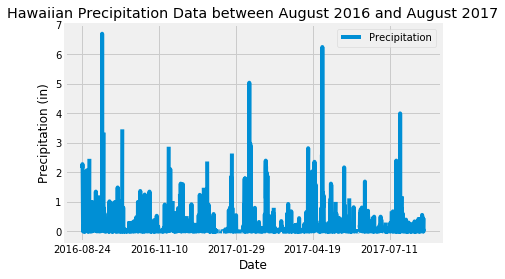

In [52]:
#Use Pandas Plotting with Matplotlib to plot the precipitation data

#Create the bar chart from the precip_df dataframe
precip_df.plot()

#Format the bar chart
plt.title('Hawaiian Precipitation Data between August 2016 and August 2017')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

#Print the figure
plt.show()

In [15]:
#Use Pandas and Numpy to calcualte the summary statistics for the precipitation data
precip_mean = precip_df['Precipitation'].mean()
precip_median = precip_df['Precipitation'].median()
precip_variance = precip_df['Precipitation'].var()
precip_std = precip_df['Precipitation'].std()
precip_sem = precip_df['Precipitation'].sem()

#Combine the statistical values into a summary table
summary_statistics = pd.DataFrame([precip_mean, precip_median, precip_variance, precip_std, precip_sem],['Mean', 'Median', 'Variance', 'Standard Deviation', 'Standard Error of the Mean'], columns = ['Value'])

#Print summary statistics table
summary_statistics

,Value
Mean,0.176462
Median,0.020000
Variance,0.211865
Standard Deviation,0.460288
Standard Error of the Mean,0.010254


### Station Analysis

In [16]:
#Design a query to show how many stations are available in this dataset.
unique_stations_number = session.query(measurement.station).distinct().count()
    #or unique_stations_number = engine.execute('select distinct(station) from measurement').fetchall()
    #https://stackoverflow.com/questions/17223174/returning-distinct-rows-in-sqlalchemy-with-sqlite

#Print the result
print(f'There are {unique_stations_number} unique stations in the Measurements dataset.')

There are 9 unique stations in the Measurements dataset.


In [17]:
#What are the most active stations?(i.e. what stations have the most rows)?

#Design a query to list the stations and the counts in descending order.
unique_stations_list = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
    #https://docs.sqlalchemy.org/en/13/orm/query.html
    #or unique_stations_list = engine.execute('Select station, count(station) from measurement Group by station Order by count(station) desc').fetchall()

#Pull the query result into a dataframe
active_stations_df = pd.DataFrame(unique_stations_list, columns = ['Station', 'Count'])

#Print the resulting dataframe
active_stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
#Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station.

#Obtain the station id of the most active station
most_active_station = active_stations_df.iloc[0,0]
print(f'The most active station is {most_active_station}.')

#Find the lowest recorded temperature at the most active station
lowest_temperature = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
    #https://docs.sqlalchemy.org/en/13/orm/query.html
print(f'The lowest temperature recorded at Station {most_active_station} is {lowest_temperature}.')

#Find the highest recorded temperature at the most active station
highest_temperature = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
print(f'The highest temperature recorded at Station {most_active_station} is {highest_temperature}.')

#Find the highest recorded temperature at the most active station
average_temperature = round(session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station).scalar(),2)
print(f'The average temperature recorded at Station {most_active_station} is {average_temperature}.')

The most active station is USC00519281.
The lowest temperature recorded at Station USC00519281 is 54.0.
The highest temperature recorded at Station USC00519281 is 85.0.
The average temperature recorded at Station USC00519281 is 71.66.


In [19]:
#Choose the station with the highest number of temperature observations. Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

#Obtain the station id of the most active station.
print(f'The most active station is {most_active_station}.')

#Perform a query to retrieve the temperature data for the most active station in the previous year
most_active_temp_query = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).filter(measurement.date >= year_ago).filter(measurement.date <= last_date)

#Save the query results as a Pandas DataFrame and set the index to the date column
most_active_temp_df = pd.DataFrame(most_active_temp_query, columns = ['Date', 'Temperature'])
most_active_temp_df = most_active_temp_df.set_index('Date')

#Print the resulting dataframe
most_active_temp_df

The most active station is USC00519281.


,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


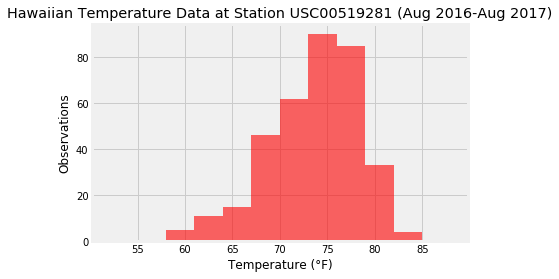

In [51]:
#Use the most_active_temp_df dataframe to create a histogram modelling the data.
most_active_temp_df['Temperature'].plot.hist(bins = [52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88], color="red", alpha=0.6)

#Format the histogram
plt.title(f'Hawaiian Temperature Data at Station {most_active_station} (Aug 2016-Aug 2017)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Observations')

#Print the figure
plt.show()

# Bonus Analysis

### Temperature Analysis I

In [21]:
#Identify the average temperature in June and December at all stations across all available years in the dataset.

#Design two seperate queries to return all temperature records taken in June and December, respectively.
june_temp_query = session.query(measurement.date, measurement.tobs).filter(measurement.date.like('%-06-%')).all()
    #https://stackoverflow.com/questions/3325467/sqlalchemy-equivalent-to-sql-like-statement
december_temp_query = session.query(measurement.date, measurement.tobs).filter(measurement.date.like('%-12-%')).all()

#Convert the query results into a Pandas dataframe
june_temp_df = pd.DataFrame(june_temp_query, columns = ['Date', 'Temperature'])
december_temp_df = pd.DataFrame(december_temp_query, columns = ['Date', 'Temperature'])

#Perform relevant calculations
june_temp_count = len(june_temp_df)
june_temp_avg = round(june_temp_df['Temperature'].mean(), 2)
december_temp_count = len(december_temp_df)
december_temp_avg = round(december_temp_df['Temperature'].mean(), 2)

#Print results
print(f'Based on the {june_temp_count} temperature records taken in the month of June, the average temperature in June is {june_temp_avg}° F.')
print(f'Based on the {december_temp_count} temperature records taken in the month of December, the average temperature in December is {december_temp_avg}° F.')

Based on the 1700 temperature records taken in the month of June, the average temperature in June is 74.94° F.
Based on the 1517 temperature records taken in the month of December, the average temperature in December is 71.04° F.


In [22]:
#Use an unpaired t-test to determine whether the difference in the means, if any, is statistically significant. 
from scipy.stats import ttest_ind
print(ttest_ind(june_temp_df['Temperature'], december_temp_df['Temperature']))

print(f'From the result of the unpaired t-test, we reject the null hypothesis that the average temperatures in June and December are equal.')

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)
From the result of the unpaired t-test, we reject the null hypothesis that the average temperatures in June and December are equal.


### Temperature Analysis II

In [23]:
#Define this function called `calc_temps` that accepts start date and end date in the format '%Y-%m-%d' 
#and returns the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [67]:
#Define the beginning and ending dates of a hypothetical trip to Hawaii
start_date = '2017-02-05'
end_date = '2017-02-15'

#Use these dates as inputs for the calc_temps function
results = calc_temps(start_date, end_date)

#Save the return values
min_temp = results[0][0]
avg_temp = results[0][1]
max_temp = results[0][2]
range_temp = max_temp-min_temp

#Pull the avg_temp into a dataframe
avg_temp_df = pd.DataFrame([avg_temp], columns = ['Average Temperature'])

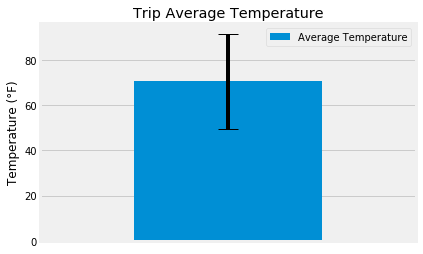

In [81]:
#Plot min_temp, avg_temp, and max_temp as a bar chart

#Create the bar chart
avg_temp_df.plot.bar(yerr = range_temp, capsize = 10)
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html#pandas.DataFrame.plot
    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.errorbar.html

#Format the bar chart
tick_locations = [value for value in avg_temp_df['Average Temperature']]
plt.xticks(tick_locations, '', rotation="vertical")
plt.title(f'Trip Average Temperature')
plt.ylabel('Temperature (°F)')

#Print the figure
plt.show()

### Daily Rainfall Average

In [26]:
#Define this function that calculates the daily normals 
#(i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

In [27]:
#Create a list of the dates between the start_date and end_date defined in the previous section
vacation_dates = pd.date_range(start=start_date,end=end_date)

#Create empty lists to hold the return values of the daily_normals function
tmin = []
tavg = []
tmax = []

#Create an empty list to hold the vacation dates
vacation_dates_list = []

#Use each date from vacation_dates as input to the daily_normals function and record the return values
for date_stamp in vacation_dates:
    vacation_dates_list.append(dt.date.strftime(date_stamp, "%Y-%m-%d"))
    tmin.append(daily_normals(dt.date.strftime(date_stamp, "%m-%d"))[0][0])
    tavg.append(daily_normals(dt.date.strftime(date_stamp, "%m-%d"))[0][1])
    tmax.append(daily_normals(dt.date.strftime(date_stamp, "%m-%d"))[0][2])

In [28]:
#Combine the vacation_dates_list and the tmin, tavg, and tmax lists into a single dataframe
normals_df = pd.DataFrame({'Date': vacation_dates_list,
                          'TMin': tmin,
                          'TAvg': tavg,
                          'TMax': tmax})

#Set the Date columns as the index
normals_df = normals_df.set_index('Date')

#Print the normals_df dataframe
normals_df

,TMin,TAvg,TMax
Date,,,
2017-02-05,59.0,69.684211,80.0
2017-02-06,58.0,70.389831,77.0
2017-02-07,60.0,69.000000,77.0
2017-02-08,56.0,66.754386,74.0
2017-02-09,57.0,67.589286,75.0
2017-02-10,56.0,68.416667,76.0
2017-02-11,61.0,69.250000,79.0
2017-02-12,60.0,69.157895,78.0
2017-02-13,58.0,70.362069,80.0


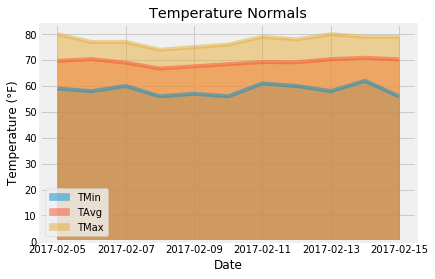

In [50]:
#Create an area plot from the normals_df dataframe
normals_df.plot.area(stacked=False)
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html
    
#Format the area plot
plt.title(f'Temperature Normals')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

#Print the figure
plt.show()